In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sns.set_theme()

# import utils
import sys
sys.path.append('../../../utils')
import price_models, rv_estimators

In [31]:
%load_ext autoreload
%autoreload 2

## Parameters

In [112]:
# Heston model parameters
mu = 0 # we don't care about the drift here
# using parameters from https://www.princeton.edu/~yacine/liquidity.pdf
theta = 0.1 # long term volatility
kappa = 5 # mean reversion coefficient
sigma = 0.5 # volatility of volatility
rho = -0.3 # correlation between the asset and its variance
nu0 = theta # initial variance
assert 2*kappa*theta > sigma**2, "Feller condition not satisfied"

# microstructure noise parameters
sigma_eps = 0.001 # standard deviation of the noise, as proposed in https://www.princeton.edu/~yacine/liquidity.pdf

# simulation parameters
S0 = 100 # initial price
T = 1/365 # 1 day (no need for 1/252 here as it's days, not trading days)
dt = 1/(365*24*60*60) # 1 second
M = 1000 # number of simulations

# estimation parameters
K = 300 # number of bins

In [113]:
all_iv_real = np.zeros(M) # real integrated variance
# 4 different estimators
all_iv_naive_est_HF = np.zeros(M) # naive integrated variance estimate, high frequency (1s)
all_iv_naive_est_LF = np.zeros(M) # naive integrated variance estimate, low frequency (5min)
all_iv_multigrid_est = np.zeros(M) # multigrid integrated variance estimate
all_iv_best_est = np.zeros(M) # best integrated variance estimate

for i in tqdm(range(M)):
    heston = price_models.Heston(mu, sigma, theta, rho, kappa, nu0)
    S, nu = heston.simulate(T, dt, S0)
    if (nu<=0).any():
        print(f"Negative variance in simulation {i}")
    X = np.log(S) # latent log-price process
    microstructure_noise = np.random.normal(loc=0, scale=sigma_eps, size=X.shape)
    Y = X + microstructure_noise # observed log-price process
    all_iv_real[i] = np.sum(nu.values)*dt # discrete integral of the variance process
    hf = pd.Timedelta('1s')
    lf = pd.Timedelta('5min')
    all_iv_naive_est_HF[i] = rv_estimators.rv_naive(ts=Y, tau=hf, verbose=False)
    all_iv_naive_est_LF[i] = rv_estimators.rv_naive(ts=Y, tau=lf, verbose=False)
    all_iv_multigrid_est[i] = rv_estimators.rv_multigrid(ts=Y, tau=hf, K=K, verbose=False)
    all_iv_best_est[i] = rv_estimators.rv_best(ts=Y, tau=hf, K=K, verbose=False)

100%|██████████| 1000/1000 [15:09<00:00,  1.10it/s]


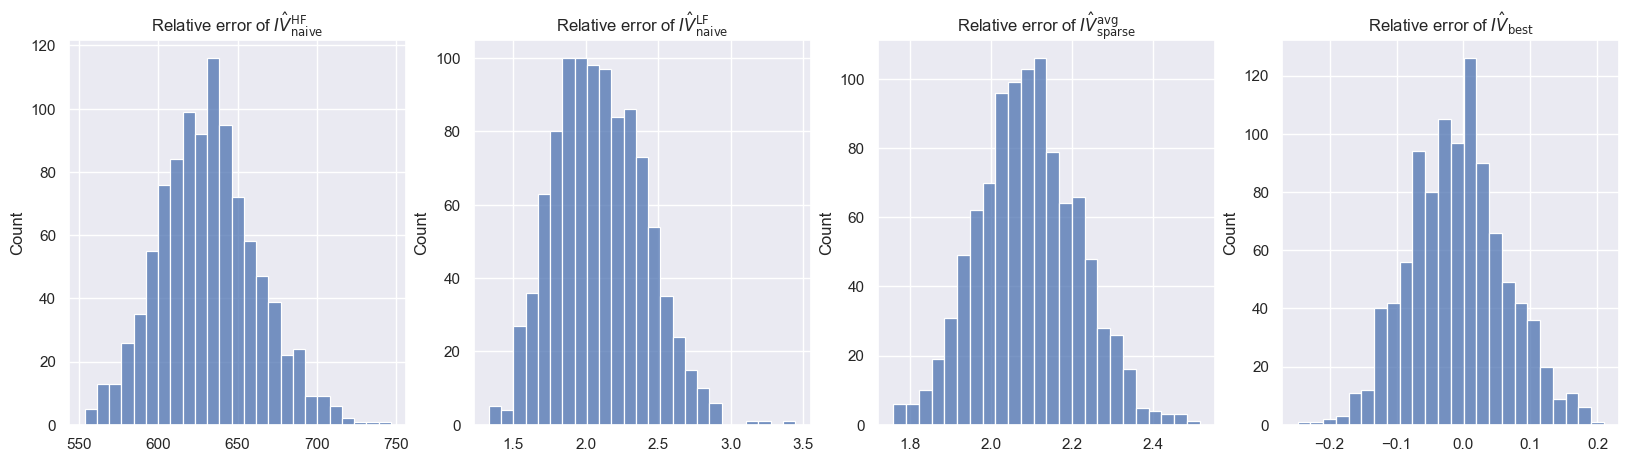

In [119]:
# M=1000
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.histplot((all_iv_naive_est_HF-all_iv_real)/all_iv_real, ax=ax[0])
ax[0].set_title(r'Relative error of $\hat{IV}_\text{naive}^\text{HF}$')
sns.histplot((all_iv_naive_est_LF-all_iv_real)/all_iv_real, ax=ax[1])
ax[1].set_title(r'Relative error of $\hat{IV}_\text{naive}^\text{LF}$')
sns.histplot((all_iv_multigrid_est-all_iv_real)/all_iv_real, ax=ax[2])
ax[2].set_title(r'Relative error of $\hat{IV}_\text{sparse}^\text{avg}$')
sns.histplot((all_iv_best_est-all_iv_real)/all_iv_real, ax=ax[3])
ax[3].set_title(r'Relative error of $\hat{IV}_\text{best}$')
plt.show()

In [121]:
rel_err = ((all_iv_best_est-all_iv_real)/all_iv_real)

In [123]:
rel_err.mean(), rel_err.std()

(-0.008385677756335756, 0.07135623559243987)

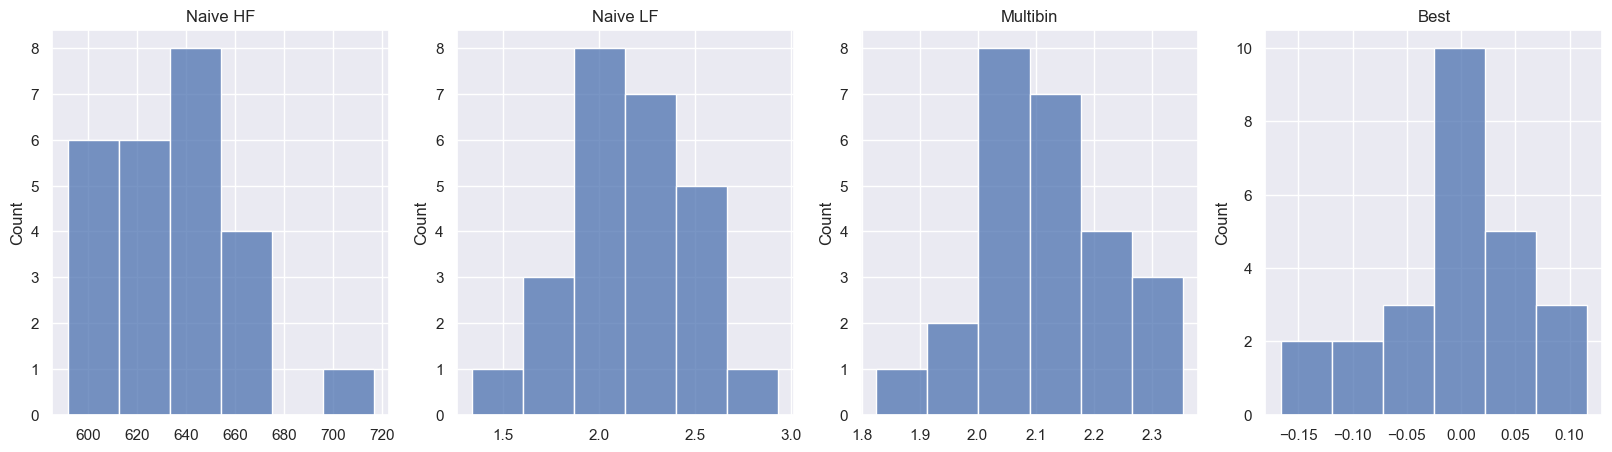

In [110]:
# # M=25
# fig, ax = plt.subplots(1, 4, figsize=(20, 5))
# sns.histplot((all_iv_naive_est_HF-all_iv_real)/all_iv_real, ax=ax[0])
# ax[0].set_title("Naive HF")
# sns.histplot((all_iv_naive_est_LF-all_iv_real)/all_iv_real, ax=ax[1])
# ax[1].set_title("Naive LF")
# sns.histplot((all_iv_multigrid_est-all_iv_real)/all_iv_real, ax=ax[2])
# ax[2].set_title("Multibin")
# sns.histplot((all_iv_best_est-all_iv_real)/all_iv_real, ax=ax[3])
# ax[3].set_title("Best")
# plt.show()